In [ ]:
import geocube
import rioxarray 
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
from dask.distributed import Client

client = Client(n_workers=18)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 18
Total threads: 36,Total memory: 31.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54152,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:54221,Total threads: 2
Dashboard: http://127.0.0.1:54243/status,Memory: 1.76 GiB
Nanny: tcp://127.0.0.1:54155,


2025-10-02 09:41:13,223 - distributed.scheduler - WARNING - Worker failed to heartbeat for 37895s; attempting restart: <WorkerState 'tcp://127.0.0.1:54219', name: 7, status: running, memory: 0, processing: 0>
2025-10-02 09:41:13,236 - distributed.scheduler - WARNING - Worker failed to heartbeat for 37895s; attempting restart: <WorkerState 'tcp://127.0.0.1:54220', name: 5, status: running, memory: 0, processing: 0>
2025-10-02 09:41:13,236 - distributed.scheduler - WARNING - Worker failed to heartbeat for 37895s; attempting restart: <WorkerState 'tcp://127.0.0.1:54221', name: 0, status: running, memory: 0, processing: 0>
2025-10-02 09:41:13,236 - distributed.scheduler - WARNING - Worker failed to heartbeat for 37895s; attempting restart: <WorkerState 'tcp://127.0.0.1:54222', name: 8, status: running, memory: 0, processing: 0>
2025-10-02 09:41:13,237 - distributed.scheduler - WARNING - Worker failed to heartbeat for 37896s; attempting restart: <WorkerState 'tcp://127.0.0.1:54225', name: 1

# Create Population Map

In [2]:
### Process GPW data

country_pop = pd.read_csv(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Data\Data_in\UN Population Estimates\unpopulation_dataportal_20250902202059.csv")
country_pop.loc[country_pop.IndicatorId == 49,"Indicator"] = "Total Population"
country_pop.loc[country_pop.IndicatorId == 47,"Indicator"] = "Total Births"

country_pop = country_pop[["Indicator", "LocationId", "Location", "Iso3", 'Time', 'Value']]
country_pop = country_pop.pivot(index=["LocationId","Location","Iso3","Time"], columns="Indicator").reset_index()
country_pop.columns = ['_'.join(col).replace('_', '') for col in country_pop.columns.values]
country_pop["born_ratio"] = country_pop["ValueTotal Births"]  / country_pop["ValueTotal Population"]  

gpw_years = np.array([2000, 2005, 2010, 2015, 2020])
country_pop['year_gpw'] = country_pop['Time'].apply(lambda y: gpw_years[np.abs(gpw_years - y).argmin()])
country_pop = country_pop.groupby(by=['LocationId','Iso3','year_gpw']).born_ratio.mean().reset_index()

In [3]:
### Process GPW data

# GPW map with IDs
gpw_country_ids = gpd.read_file(r"E:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_national_identifier_grid_rev11_15_min.shp")
gpw_country_ids = gpw_country_ids[['Value', 'ISOCODE', 'NAME0', 'MEANUNITKM', 'geometry']]
whole_world = gpw_country_ids[["geometry"]].dissolve()
# Add born_ratio to gpw_country_ids
gpw_country_ids = gpw_country_ids.merge(country_pop, left_on="Value", right_on="LocationId", validate="1:m", how="inner")

# Keep only the ones that are in DHS
dhs = pd.read_stata(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Data\Data_in\DHS\DHSBirthsGlobalAnalysis_07272025.dta")
dhs_iso = dhs.code_iso3.unique().tolist()
gpw_country_ids = gpw_country_ids[gpw_country_ids.ISOCODE.isin(dhs_iso)]
print(f"Number of countries: {gpw_country_ids.ISOCODE.unique()}")

# Clean columns
gpw_country_ids = gpw_country_ids[["geometry", "year_gpw", "born_ratio"]].rename(columns={"year_gpw":"time"})

Number of countries: ['ALB' 'AGO' 'BGD' 'ARM' 'BOL' 'MMR' 'BDI' 'KHM' 'CMR' 'CAF' 'TCD' 'COL'
 'COM' 'COD' 'BEN' 'DOM' 'ETH' 'GAB' 'GMB' 'GHA' 'GTM' 'GIN' 'GUY' 'HTI'
 'HND' 'IND' 'CIV' 'JOR' 'KEN' 'KGZ' 'LSO' 'LBR' 'MDG' 'MWI' 'MLI' 'MRT'
 'MDA' 'MAR' 'MOZ' 'NAM' 'NIC' 'NGA' 'PAK' 'PER' 'PHL' 'TLS' 'RWA' 'SEN'
 'SLE' 'ZAF' 'ZWE' 'SWZ' 'TJK' 'TGO' 'UGA' 'EGY' 'TZA' 'BFA' 'ZMB']


In [4]:
### Gridded Population of the World
gpw_tifs_paths = [
    r"e:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2020_15_min.tif", 
    r"e:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2000_15_min.tif", 
    r"e:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2005_15_min.tif", 
    r"e:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2010_15_min.tif", 
    r"e:\Datasets\Gridded Population of the World\15-minutes\gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2015_15_min.tif",
]
gpw_tifs_paths.sort()

tifs = []

for tif_path in gpw_tifs_paths:

    # Load and clean tif
    tif = rioxarray.open_rasterio(tif_path)
    tif = tif.sel(band=1).drop_vars(["band", "spatial_ref"])
    
    # Add year
    tif_year = tif_path.replace("_15_min.tif", "")[-4:]
    tif = tif.expand_dims(time=[int(tif_year)]) 
    tif.name = "total_population"
    tifs += [tif]

pop_dataset = xr.concat(tifs, dim="time").to_dataset()
pop_dataset["total_population"] = pop_dataset.total_population.where(pop_dataset["total_population"]>0, np.nan)
pop_dataset = pop_dataset.rio.write_crs("EPSG:4326")

In [5]:
from geocube.api.core import make_geocube

grid_ds_years = []
for year in gpw_country_ids.time.unique():
    country_grid_ds_year = make_geocube(
        vector_data=gpw_country_ids[gpw_country_ids.time == year],
        measurements=['born_ratio'], # The column to burn into the raster
        like=pop_dataset,          # Use this raster as a template for the output grid
        fill=np.nan                     # The "no data" value for cells without a polygon
    )
    country_grid_ds_year = country_grid_ds_year.expand_dims(time=[int(year)]) 
    
    grid_ds_years += [country_grid_ds_year]


# # Extract the DataArray from the Dataset
# country_grid = country_grid_ds['country_id']
ratio_dataset = xr.concat(grid_ds_years, dim="time")

In [6]:
## Create a single dataset with both variables
dataset = xr.combine_by_coords([pop_dataset, ratio_dataset])
dataset["total_population"] = dataset["total_population"].where(dataset["born_ratio"].notnull(), np.nan)

C:\Users\abbat\AppData\Local\Temp\ipykernel_35560\2466988600.py:2: FutureWarning: In a future version of xarray the default value for compat will change from compat='no_conflicts' to compat='override'. This is likely to lead to different results when combining overlapping variables with the same name. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set compat explicitly.
  dataset = xr.combine_by_coords([pop_dataset, ratio_dataset])


# Create Climate map

In [7]:
# --- 1. Load the datset ---

climate_ds = xr.open_dataset(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Data\Data_out\Climate_shocks_v11.nc")
climate_ds = climate_ds.sel(time=slice("01-01-1990","12-31-2020"))
climate_ds = climate_ds[["stdm_t"]]

climate_ds_6m = climate_ds.rolling(time=6, center=False).mean()
climate_ds_9m = climate_ds.rolling(time=9, center=False).mean()
climate_ds_6m ["stdm_t_pos_6m"] = climate_ds_6m .stdm_t.where((climate_ds_6m .stdm_t > 0) | (climate_ds_6m .stdm_t.isnull()), 0)
climate_ds_6m ["stdm_t_neg_6m"] = climate_ds_6m .stdm_t.where((climate_ds_6m .stdm_t < 0) | (climate_ds_6m .stdm_t.isnull()), 0)
climate_ds_9m ["stdm_t_pos_9m"] = climate_ds_9m .stdm_t.where((climate_ds_9m .stdm_t > 0) | (climate_ds_9m .stdm_t.isnull()), 0)
climate_ds_9m ["stdm_t_neg_9m"] = climate_ds_9m .stdm_t.where((climate_ds_9m .stdm_t < 0) | (climate_ds_9m .stdm_t.isnull()), 0)
climate_ds_6m = climate_ds_6m.drop_vars(["stdm_t"])
climate_ds_9m = climate_ds_9m.drop_vars(["stdm_t"])

climate_ds = xr.combine_by_coords([climate_ds_6m, climate_ds_9m]).rename_dims({"lat":"y", "lon":"x"}).rename_vars({"lat":"y", "lon":"x"})

In [8]:
import gc
from dask.diagnostics import ProgressBar

# Make monthly so it matches the climate_ds structure
dataset["time"] = pd.to_datetime(dataset.time, format="%Y")
dataset = dataset.interp_like(climate_ds, method="linear", kwargs={"fill_value":"extrapolate"})
dataset = xr.combine_by_coords([dataset, climate_ds])
encoding = {
    var: {"zlib": True, "complevel": 6} for var in dataset.data_vars
}
dataset.to_netcdf(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Data\Data_proc\effect_map_variables_high_res.nc", encoding=encoding)

In [9]:
dataset = xr.open_dataset(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Data\Data_proc\effect_map_variables_high_res.nc")
dataset

<xarray.Dataset> Size: 19GB
Dimensions:           (time: 372, y: 721, x: 1440)
Coordinates:
    spatial_ref       int64 8B ...
  * time              (time) datetime64[ns] 3kB 1990-01-01 ... 2020-12-01
  * x                 (x) float64 12kB -179.8 -179.5 -179.2 ... 179.8 180.0
  * y                 (y) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
Data variables:
    total_population  (time, y, x) float64 3GB ...
    born_ratio        (time, y, x) float64 3GB ...
    stdm_t_pos_6m     (time, y, x) float64 3GB ...
    stdm_t_neg_6m     (time, y, x) float64 3GB ...
    stdm_t_pos_9m     (time, y, x) float64 3GB ...
    stdm_t_neg_9m     (time, y, x) float64 3GB ...

In [10]:
## Add climate bands
kg_bands = xr.open_dataset(r"E:\Datasets\Köppen-Geiger Climate Classification\KG_1986-2010.grd", engine="rasterio").band_data.sel(band=1)
kg_bands = kg_bands.drop_vars(["band", "spatial_ref"])

# Your list of "category 3" categories
categories_3 = [
    'Af', 'Am', 'As', 'Aw',
    'BSh', 'BSk', 'BWh', 'BWk',
    'Cfa', 'Cfb', 'Cfc', 'Csa', 'Csb', 'Csc', 'Cwa', 'Cwb', 'Cwc',
    'Dfa', 'Dfb', 'Dfc', 'Dfd', 'Dsa', 'Dsb', 'Dsc', 'Dsd', 'Dwa', 'Dwb', 'Dwc', 'Dwd',
    'EF', 'ET', 'Ocean'
]

# --- Create the DataArray for "category 3" ---

# Create a new DataArray with the same dimensions and coordinates
categorical_da_3 = xr.full_like(kg_bands, fill_value='', dtype=object)

# Create a numpy array of the categories for efficient indexing
category_array_3 = np.array(categories_3)

# Map the integer values to the "category 3" strings
# Subtract 1 because array indexing is 0-based
categorical_da_3.values = category_array_3[kg_bands.values.astype(int) - 1]


# --- Create the DataArray for "category 1" ---

# Your mapping from "category 3" to "category 1"
categories_3_to_1 = {
    'Af': 1, 'Am': 1, 'As': 1, 'Aw': 1,
    'BSh': 2, 'BSk': 2, 'BWh': 2, 'BWk': 2,
    'Cfa': 3, 'Cfb': 3, 'Cfc': 3, 'Csa': 3, 'Csb': 3, 'Csc': 3, 'Cwa': 3, 'Cwb': 3, 'Cwc': 3,
    'Dfa': 4, 'Dfb': 4, 'Dfc': 4, 'Dfd': 4, 'Dsa': 4, 'Dsb': 4, 'Dsc': 4, 'Dsd': 4, 'Dwa': 4, 'Dwb': 4, 'Dwc': 4, 'Dwd': 4,
    'EF': np.nan, 'ET': np.nan, 'Ocean': np.nan,
}

# Create another new DataArray for the "category 1" data
categorical_da_1 = xr.full_like(categorical_da_3, fill_value='', dtype=object)

# A function to apply the mapping
def map_func(val):
    return categories_3_to_1.get(val)

# Use xarray's apply_ufunc to efficiently apply the mapping
categorical_da_1 = xr.apply_ufunc(np.vectorize(map_func), categorical_da_3)
categorical_da_1.name = "climate_band"
categorical_da_1 = categorical_da_1.interp_like(dataset, method="nearest")

In [11]:
### Get coefficients from the regressions: 
import numpy as np
import plot_tools_b as pt
import copy # Import the copy module


def set_nonsignificant_to_zero(coeffs_dict):
    """
    Sets coefficients to zero if their confidence interval crosses zero.

    Args:
        coeffs_dict (dict): A dictionary containing coefficient details
                           (coef, lower, upper lists).

    Returns:
        dict: A new dictionary with non-significant coefficients set to 0.
    """
    # Create a deep copy to avoid modifying the original dictionary
    filtered_coeffs = copy.deepcopy(coeffs_dict)

    # Iterate over each variable (e.g., 'inutero_b_avg_neg_int')
    for key, values in filtered_coeffs.items():
        coef_list = values['coef']
        lower_list = values.get('lower', []) # Use .get for safety
        upper_list = values.get('upper', [])

        # Ensure all lists have the same length
        if not (len(coef_list) == len(lower_list) == len(upper_list)):
            print(f"Warning: Mismatched list lengths in {key}. Skipping filtering.")
            continue

        # Iterate over each individual coefficient in the list
        for i in range(len(coef_list)):
            lower_bound = lower_list[i]
            upper_bound = upper_list[i]

            # Check for NaNs, as they can't be compared
            if np.isnan(lower_bound) or np.isnan(upper_bound):
                continue

            # The condition for non-significance: lower is negative AND upper is positive
            if lower_bound < 0 and upper_bound > 0:
                coef_list[i] = 0.0  # Set non-significant coefficient to zero

    return filtered_coeffs

all_climate_coeffs = {}
for i, zone in enumerate(["Tropical", "Arid", "Temperate"]):

    coefs = pt.extract_coefficients_and_CI_latex(fr"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Outputs\heterogeneity\climate_band_1\linear_dummies_true_spi1_b_avg_stdm_t semester - {zone} standard_fe standard_sym.tex")
    all_climate_coeffs[i+1] = set_nonsignificant_to_zero(coefs["temp"]["cell1"])

total_coeffs = {}

for zone, coeffs in all_climate_coeffs.items():

    # --- High Temperature (Positive Shocks) ---
    # Sum of coefficients for in-utero and first year of life (1-12 months)
    high_temp_iushocks = (
        np.nansum(coeffs['inutero_b_avg_pos_int']['coef']) +
        np.nansum(coeffs['born_1m6m_b_avg_pos_int']['coef']) +
        np.nansum(coeffs['born_6m12m_b_avg_pos_int']['coef'])
    )
    # Sum of coefficients for ONLY the first year of life (1-12 months)
    high_temp_1yearshock = (
        np.nansum(coeffs['born_1m6m_b_avg_pos_int']['coef']) +
        np.nansum(coeffs['born_6m12m_b_avg_pos_int']['coef'])
    )

    # --- Low Temperature (Negative Shocks) ---
    # Sum of coefficients for in-utero and first year of life (1-12 months)
    low_temp_iushocks = (
        np.nansum(coeffs['inutero_b_avg_neg_int']['coef']) +
        np.nansum(coeffs['born_1m6m_b_avg_neg_int']['coef']) +
        np.nansum(coeffs['born_6m12m_b_avg_neg_int']['coef'])
    )
    # Sum of coefficients for ONLY the first year of life (1-12 months)
    low_temp_1yearshock = (
        np.nansum(coeffs['born_1m6m_b_avg_neg_int']['coef']) +
        np.nansum(coeffs['born_6m12m_b_avg_neg_int']['coef'])
    )

    total_coeffs[zone] = {
        'high_temp_iushocks': high_temp_iushocks.item(),
        'high_temp_1yearshock': high_temp_1yearshock.item(),
        'low_temp_iushocks': low_temp_iushocks.item(),
        'low_temp_1yearshock': low_temp_1yearshock.item()
    }

# Print the results for one zone to verify
print("Calculated coefficients for Zones:")
print(total_coeffs)


Calculated coefficients for Zones:
{1: {'high_temp_iushocks': 4.117, 'high_temp_1yearshock': 1.815, 'low_temp_iushocks': -5.395, 'low_temp_1yearshock': -1.544}, 2: {'high_temp_iushocks': 2.342, 'high_temp_1yearshock': 0.826, 'low_temp_iushocks': -3.058, 'low_temp_1yearshock': 0.0}, 3: {'high_temp_iushocks': 3.096, 'high_temp_1yearshock': 2.424, 'low_temp_iushocks': -1.805, 'low_temp_1yearshock': -1.805}}


In [12]:
# Instead of looping over the large 3D dataset, we first create 2D maps 
# of the coefficients. This is much faster as it avoids building a deep Dask graph.

climate_band = categorical_da_1
# Initialize coefficient maps with NaNs, matching the spatial dimensions and chunking of the climate band map.
# dataset['climate_band'] is 2D (y, x), so these maps will also be 2D.
high_temp_iushocks_map = xr.full_like(climate_band, np.nan, dtype=float)
high_temp_1yearshock_map = xr.full_like(climate_band, np.nan, dtype=float)
low_temp_iushocks_map = xr.full_like(climate_band, np.nan, dtype=float)
low_temp_1yearshock_map = xr.full_like(climate_band, np.nan, dtype=float)

# Fill the maps. This loop is efficient because it operates on 2D arrays.
for zone, values in total_coeffs.items():
    print(zone)
    print(f"High Temp Attributable Deaths in the first year (in utero shocks): {values['high_temp_iushocks']}")
    print(f"Low Temp Attributable Deaths in the first year (in utero shocks): {values['low_temp_iushocks']}")
    print(f"High Temp Attributable Deaths in the first year (1st year shocks): {values['high_temp_1yearshock']}")
    print(f"Low Temp Attributable Deaths in the first year (1st year shocks): {values['low_temp_1yearshock']}")
    
    # Create a boolean mask where the climate band matches the current zone
    mask = (climate_band == zone)

    # Use .where() to fill in the values.
    # da.where(condition, other) keeps values where condition is True, and replaces with 'other' where False.
    # We use ~mask so we keep existing values where it does NOT match, and fill in the new coefficient where it DOES match.
    high_temp_iushocks_map = high_temp_iushocks_map.where(~mask, values["high_temp_iushocks"])
    high_temp_1yearshock_map = high_temp_1yearshock_map.where(~mask, values["high_temp_1yearshock"])
    low_temp_iushocks_map = low_temp_iushocks_map.where(~mask, -values["low_temp_iushocks"])
    low_temp_1yearshock_map = low_temp_1yearshock_map.where(~mask, -values["low_temp_1yearshock"])
    assert high_temp_iushocks_map.max() > 0

# --- Calculate deaths in a single vectorized operation ---
# Xarray will automatically broadcast the 2D coefficient maps (y, x)
# against the 3D climate data (time, y, x). This creates a much simpler Dask graph.
dataset["pos_deaths_per_1000_childs"] = (
    dataset["stdm_t_pos_9m"] * high_temp_iushocks_map +
    dataset["stdm_t_pos_6m"] * high_temp_1yearshock_map
)

dataset["neg_deaths_per_1000_childs"] = (
    dataset["stdm_t_neg_9m"] * -low_temp_iushocks_map +
    dataset["stdm_t_neg_6m"] * -low_temp_1yearshock_map
)

# The rest of the calculations remain the same
dataset["n_childs"] = dataset["total_population"] * dataset["born_ratio"]
dataset["pos_deaths"] = dataset["n_childs"] * dataset["pos_deaths_per_1000_childs"] / 1000
dataset["neg_deaths"] = dataset["n_childs"] * dataset["neg_deaths_per_1000_childs"] / 1000

dataset["pos_deaths_per_1000_childs"] = dataset["pos_deaths_per_1000_childs"].where(dataset["pos_deaths"].notnull(), np.nan)
dataset["neg_deaths_per_1000_childs"] = dataset["neg_deaths_per_1000_childs"].where(dataset["neg_deaths"].notnull(), np.nan)
dataset["deaths_per_1000_childs"] = dataset["pos_deaths_per_1000_childs"] + dataset["neg_deaths_per_1000_childs"]

dataset["total_deaths"] = dataset["neg_deaths"] + dataset["pos_deaths"]

1
High Temp Attributable Deaths in the first year (in utero shocks): 4.117
Low Temp Attributable Deaths in the first year (in utero shocks): -5.395
High Temp Attributable Deaths in the first year (1st year shocks): 1.815
Low Temp Attributable Deaths in the first year (1st year shocks): -1.544
2
High Temp Attributable Deaths in the first year (in utero shocks): 2.342
Low Temp Attributable Deaths in the first year (in utero shocks): -3.058
High Temp Attributable Deaths in the first year (1st year shocks): 0.826
Low Temp Attributable Deaths in the first year (1st year shocks): 0.0
3
High Temp Attributable Deaths in the first year (in utero shocks): 3.096
Low Temp Attributable Deaths in the first year (in utero shocks): -1.805
High Temp Attributable Deaths in the first year (1st year shocks): 2.424
Low Temp Attributable Deaths in the first year (1st year shocks): -1.805


In [13]:
# # --- Create a sample dataset for demonstration ---

# # Map the calculated coefficients to the grid using the climate zone DataArray
# dataset["pos_deaths_per_1000_childs"] = np.nan
# dataset["neg_deaths_per_1000_childs"] = np.nan

# for zone, values in total_coeffs.items():
    
#     high_temp_attributable_deaths_1year_iushocks = values["high_temp_iushocks"]
#     high_temp_attributable_deaths_1year_1yearshock = values["high_temp_1yearshock"]
#     low_temp_attributable_deaths_1year_iushocks =  values["low_temp_iushocks"]
#     low_temp_attributable_deaths_1year_1yearshock = values["low_temp_1yearshock"]

#     print(zone)
#     print(f"High Temp Attributable Deaths in the first year (in utero shocks): {high_temp_attributable_deaths_1year_iushocks}")
#     print(f"Low Temp Attributable Deaths in the first year (in utero shocks): {low_temp_attributable_deaths_1year_iushocks}")
#     print(f"High Temp Attributable Deaths in the first year (1st year shocks): {high_temp_attributable_deaths_1year_1yearshock}")
#     print(f"Low Temp Attributable Deaths in the first year (1st year shocks): {low_temp_attributable_deaths_1year_1yearshock}")
    
#     dataset["pos_deaths_per_1000_childs"] = dataset["pos_deaths_per_1000_childs"].where(
#         dataset['climate_band']!=zone,
#         dataset["stdm_t_pos_9m"] * high_temp_attributable_deaths_1year_iushocks + 
#         dataset["stdm_t_pos_6m"] * high_temp_attributable_deaths_1year_1yearshock 
#     )
#     dataset["neg_deaths_per_1000_childs"] = dataset["neg_deaths_per_1000_childs"].where(
#         dataset['climate_band']!=zone,
#         dataset["stdm_t_neg_9m"] * -low_temp_attributable_deaths_1year_iushocks + 
#         dataset["stdm_t_neg_6m"] * -low_temp_attributable_deaths_1year_1yearshock 
#     )

# dataset["n_childs"] = dataset["total_population"] * dataset["born_ratio"]
# dataset["pos_deaths"] = dataset["n_childs"] * dataset["pos_deaths_per_1000_childs"] / 1000
# dataset["neg_deaths"] = dataset["n_childs"] * dataset["neg_deaths_per_1000_childs"] / 1000

# dataset["pos_deaths_per_1000_childs"] = dataset["pos_deaths_per_1000_childs"].where(dataset["pos_deaths"].notnull(), np.nan)
# dataset["neg_deaths_per_1000_childs"] = dataset["neg_deaths_per_1000_childs"].where(dataset["neg_deaths"].notnull(), np.nan)
# dataset["deaths_per_1000_childs"] = dataset["pos_deaths_per_1000_childs"] + dataset["neg_deaths_per_1000_childs"]

# dataset["total_deaths"] = dataset["neg_deaths"] + dataset["pos_deaths"]

In [14]:
# high_temp_attributable_deaths_1year_iushocks = (1.5 + .4 + 1.1 + 0.6)
# high_temp_attributable_deaths_1year_1yearshock = (1.1 + 0.6)
# low_temp_attributable_deaths_1year_iushocks = (1.7 + 0.7 + 0.6)
# low_temp_attributable_deaths_1year_1yearshock = (1.2 + 0.5 + 0.6)

# print(f"High Temp Attributable Deaths in the first year (in utero shocks): {high_temp_attributable_deaths_1year_iushocks}")
# print(f"Low Temp Attributable Deaths in the first year (in utero shocks): {low_temp_attributable_deaths_1year_iushocks}")
# print(f"High Temp Attributable Deaths in the first year (1st year shocks): {high_temp_attributable_deaths_1year_1yearshock}")
# print(f"Low Temp Attributable Deaths in the first year (1st year shocks): {low_temp_attributable_deaths_1year_1yearshock}")

# dataset["pos_deaths_per_1000_childs"] = (
#     dataset["stdm_t_pos_9m"] * high_temp_attributable_deaths_1year_iushocks + 
#     dataset["stdm_t_pos_6m"] * high_temp_attributable_deaths_1year_1yearshock 
# )
# dataset["neg_deaths_per_1000_childs"] = (
#     dataset["stdm_t_neg_9m"] * -low_temp_attributable_deaths_1year_iushocks + 
#     dataset["stdm_t_neg_6m"] * -low_temp_attributable_deaths_1year_1yearshock 
# )

# dataset["n_childs"] = dataset["total_population"] * dataset["born_ratio"]
# dataset["pos_deaths"] = dataset["n_childs"] * dataset["pos_deaths_per_1000_childs"] / 1000
# dataset["neg_deaths"] = dataset["n_childs"] * dataset["neg_deaths_per_1000_childs"] / 1000

# dataset["pos_deaths_per_1000_childs"] = dataset["pos_deaths_per_1000_childs"].where(dataset["pos_deaths"].notnull(), np.nan)
# dataset["neg_deaths_per_1000_childs"] = dataset["neg_deaths_per_1000_childs"].where(dataset["neg_deaths"].notnull(), np.nan)
# dataset["deaths_per_1000_childs"] = dataset["pos_deaths_per_1000_childs"] + dataset["neg_deaths_per_1000_childs"]

# dataset["total_deaths"] = dataset["neg_deaths"] + dataset["pos_deaths"]

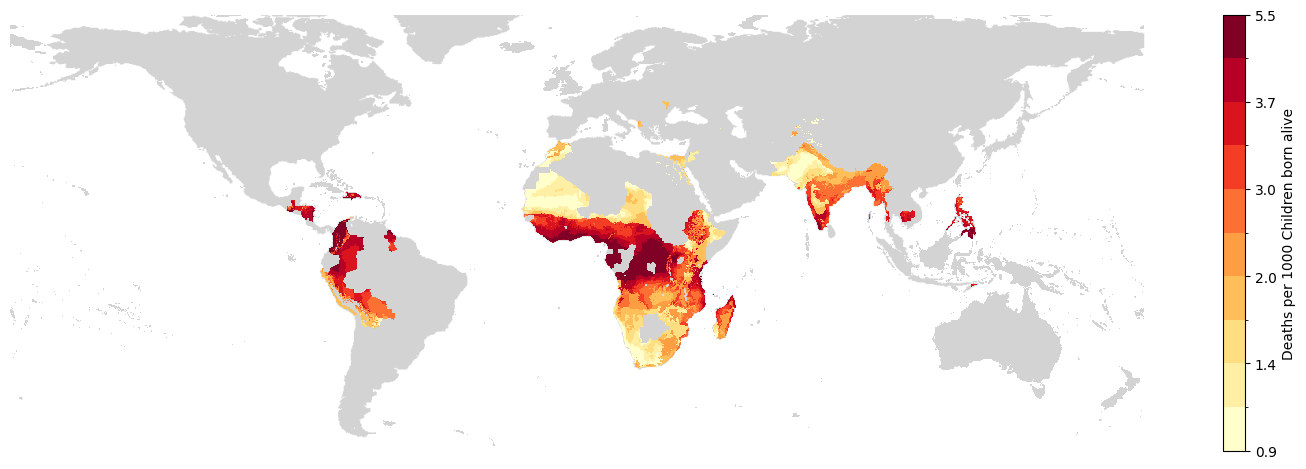

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# --- Main plotting code ---
fig, ax = plt.subplots(1, 1, figsize=(16, 5), sharex=True, sharey=True)
# fig.suptitle('Annual Climate Shock Deaths attributable to Temperature Anomalies', fontsize=16)

whole_world.plot(color="lightgray", ax=ax)
ax.set_axis_off()

# --- Plot 3: Low Temperature Deaths per 1,000 children born ---
ax3 = ax
neg_rel_deaths = dataset["deaths_per_1000_childs"].sel(y=slice(-60, 75)).mean(dim="time")
quintile_breaks = np.nanpercentile(neg_rel_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
plot_levels = np.unique([neg_rel_deaths.min()] + list(quintile_breaks) + [neg_rel_deaths.max()])
neg_rel_deaths.plot(
    ax=ax3,
    cmap='YlOrRd',  # Using a different colormap for clarity
    levels=plot_levels,
    cbar_kwargs={
        'label': 'Deaths per 1000 Children born alive',
        'format': '%.1f',  # Add this line to format the color bar labels
}
)
ax3.set_title("", fontsize=14)

# Adjust layout to prevent title overlap and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Outputs\Figures\deaths_mapping_both.png", dpi=450, bbox_inches='tight')

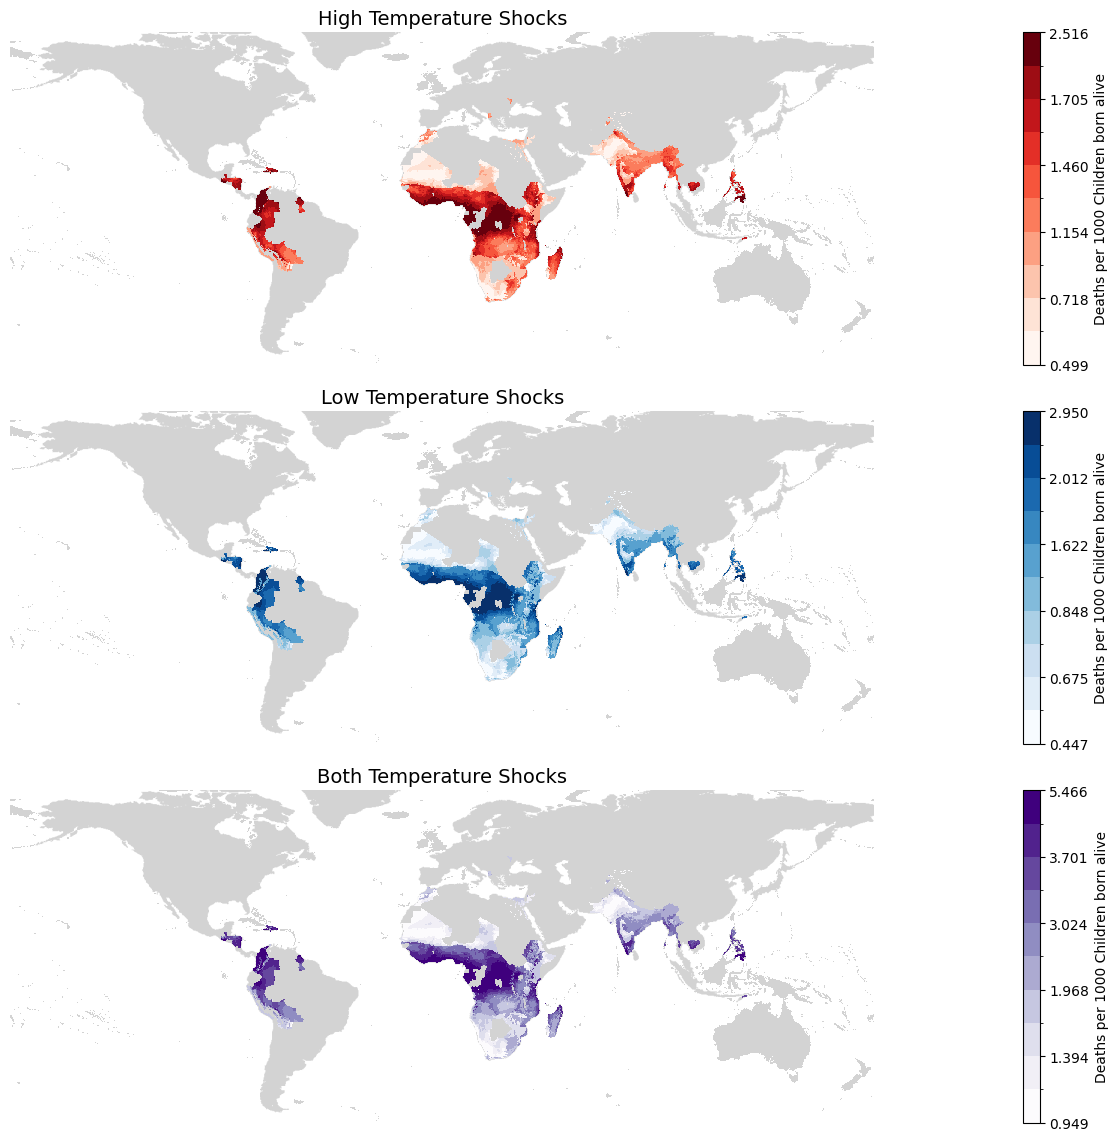

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

# --- Main plotting code ---
fig, axs = plt.subplots(3, 1, figsize=(30, 12), sharex=True, sharey=True)
# fig.suptitle('Annual Climate Shock Deaths attributable to Temperature Anomalies', fontsize=16)

for ax in axs.flatten():
    whole_world.plot(color="lightgray", ax=ax)
    ax.set_axis_off()

# --- Plot 1: Positive Deaths per 1,000 children born ---
ax1 = axs[0]
pos_rel_deaths = dataset["pos_deaths_per_1000_childs"].sel(y=slice(-60, 75)).mean(dim="time")

# Calculate the quintile breaks (20th, 40th, 60th, 80th percentiles)
quintile_breaks = np.nanpercentile(pos_rel_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
# Create the final list of levels for plotting, including the min and max
plot_levels = np.unique([pos_rel_deaths.min()] + list(quintile_breaks) + [pos_rel_deaths.max()])

# Plot with discrete levels
pos_rel_deaths.plot(
    ax=ax1,
    cmap='Reds',
    levels=plot_levels,
    cbar_kwargs={'label': 'Deaths per 1000 Children born alive'}
)
ax1.set_title("High Temperature Shocks", fontsize=14)


# --- Plot 2: Low Temperature Deaths per 1,000 children born ---
ax2 = axs[1]
neg_rel_deaths = dataset["neg_deaths_per_1000_childs"].sel(y=slice(-60, 75)).mean(dim="time")
quintile_breaks = np.nanpercentile(neg_rel_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
plot_levels = np.unique([neg_rel_deaths.min()] + list(quintile_breaks) + [neg_rel_deaths.max()])
neg_rel_deaths.plot(
    ax=ax2,
    cmap='Blues',  # Using a different colormap for clarity
    levels=plot_levels,
    cbar_kwargs={'label': 'Deaths per 1000 Children born alive'}
)
ax2.set_title("Low Temperature Shocks", fontsize=14)

# --- Plot 3: Low Temperature Deaths per 1,000 children born ---
ax3 = axs[2]
neg_rel_deaths = dataset["deaths_per_1000_childs"].sel(y=slice(-60, 75)).mean(dim="time")
quintile_breaks = np.nanpercentile(neg_rel_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
plot_levels = np.unique([neg_rel_deaths.min()] + list(quintile_breaks) + [neg_rel_deaths.max()])
neg_rel_deaths.plot(
    ax=ax3,
    cmap='Purples',  # Using a different colormap for clarity
    levels=plot_levels,
    cbar_kwargs={'label': 'Deaths per 1000 Children born alive'}
)
ax3.set_title("Both Temperature Shocks", fontsize=14)

# # --- Plot 3: Positive Total Deaths ---
# ax3 = axs[0][1]
# pos_deaths = dataset["pos_deaths"].sel(y=slice(-60, 75)).mean(dim="time")
# quintile_breaks = np.nanpercentile(pos_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
# plot_levels = np.unique([pos_deaths.min()] + list(quintile_breaks) + [pos_deaths.max()])
# pos_deaths.plot(
#     ax=ax3,
#     cmap='Reds',
#     levels=plot_levels,
#     # cbar_kwargs={'label': 'Total Deaths'}
# )
# ax3.set_title("High Temperature Shocks - Total Deaths", fontsize=16)


# # --- Plot 4: Low Temperature Total Deaths ---
# ax4 = axs[1][1]
# neg_deaths = dataset["neg_deaths"].sel(y=slice(-60, 75)).mean(dim="time")
# quintile_breaks = np.nanpercentile(neg_deaths, [10, 20, 30, 40, 50, 60, 70, 80, 90])
# plot_levels = np.unique([neg_deaths.min()] + list(quintile_breaks) + [neg_deaths.max()])
# neg_deaths.plot(
#     ax=ax4,
#     cmap='Blues', # Using a different colormap for clarity
#     levels=plot_levels,
#     # cbar_kwargs={'label': 'Total Deaths'}
# )
# ax4.set_title("Low Temperature Shocks - Total Deaths", fontsize=16)

# Adjust layout to prevent title overlap and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Outputs\Figures\deaths_mapping.png", dpi=450, bbox_inches='tight')

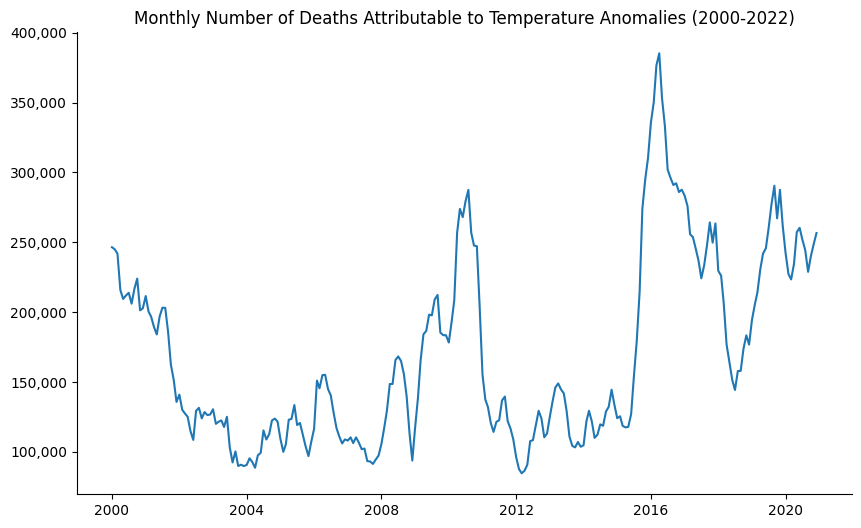

In [17]:
import seaborn as sns
import matplotlib

fig, ax = plt.subplots(1,1,figsize=(10,6) )
dataset.total_deaths.sum(dim=["x", "y"]).sel(time=slice("2000-01-01",None)).plot(ax=ax)
from matplotlib.ticker import FuncFormatter
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Monthly Number of Deaths Attributable to Temperature Anomalies (2000-2022)")
sns.despine()
plt.savefig(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Outputs\Figures\deaths_over_time.png", dpi=450, bbox_inches='tight')

In [18]:
dataset.total_deaths

<xarray.DataArray 'total_deaths' (time: 372, y: 721, x: 1440)> Size: 3GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], shape=(372, 721, 1440))
Coordinates:
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 3kB 1990-01-01 1990-02-01 ... 2020-12-01
  * x            (x) float64 12kB -179.8 -179.5 -179.2 ... 179.5 179.8 180.0
  * y            (y) float32 3kB -90.0 -89.75 -89.5 -89.25 ... 89.5 89.75 90.0

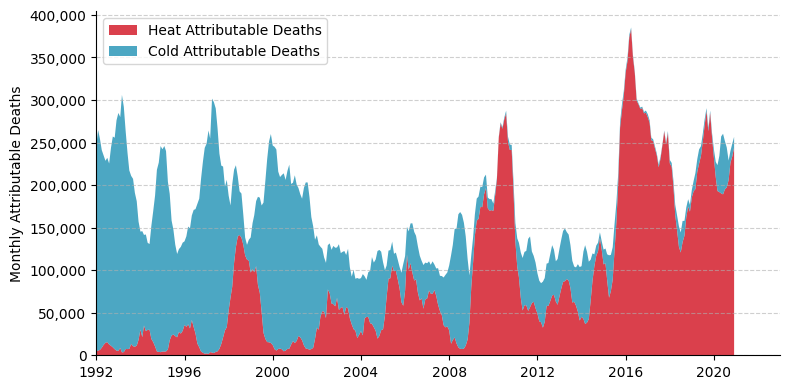

In [19]:
import seaborn as sns
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 1. Prepare the data for each variable
# Sum pos_deaths and neg_deaths over the spatial dimensions and select the time slice
time_slice = slice("1990-01-01", None)
heat_deaths = dataset.pos_deaths.sum(dim=["x", "y"]).sel(time=time_slice)
cold_deaths = dataset.neg_deaths.sum(dim=["x", "y"]).sel(time=time_slice)

# Extract the time coordinates for the x-axis
time_axis = heat_deaths.time.values

# 2. Create the plot
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

# 3. Use ax.stackplot to create the stacked area chart
ax.stackplot(
    time_axis,
    heat_deaths.values,
    cold_deaths.values,
    labels=['Heat Attributable Deaths', 'Cold Attributable Deaths'],
    colors=['#d1101f', "#1f91b4"], # A red for heat and a blue for cold
    alpha=0.8
)

# 2. Define the start and end dates as datetime objects
start_date = datetime.datetime(1992, 1, 1)
end_date = datetime.datetime(2022, 12, 31)

# 3. Apply the limits to the x-axis
ax.set_xlim(start_date, end_date)

# 4. Add a legend to identify the stacked areas
ax.legend(loc='upper left')

# --- The rest of your formatting remains the same ---

# Format the y-axis to have commas for thousands
ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(int(x), ','))
)

# Set labels and title
ax.set_ylabel("Monthly Attributable Deaths")
ax.set_xlabel("")

# Clean up the plot aesthetics
sns.despine()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the figure
plt.savefig(r"C:\Working Papers\Paper - Child Mortality and Climate Shocks\Outputs\Figures\deaths_over_time_stacked.png", dpi=450, bbox_inches='tight')

plt.show()

In [20]:
time_axis

array(['1990-01-01T00:00:00.000000000', '1990-02-01T00:00:00.000000000',
       '1990-03-01T00:00:00.000000000', '1990-04-01T00:00:00.000000000',
       '1990-05-01T00:00:00.000000000', '1990-06-01T00:00:00.000000000',
       '1990-07-01T00:00:00.000000000', '1990-08-01T00:00:00.000000000',
       '1990-09-01T00:00:00.000000000', '1990-10-01T00:00:00.000000000',
       '1990-11-01T00:00:00.000000000', '1990-12-01T00:00:00.000000000',
       '1991-01-01T00:00:00.000000000', '1991-02-01T00:00:00.000000000',
       '1991-03-01T00:00:00.000000000', '1991-04-01T00:00:00.000000000',
       '1991-05-01T00:00:00.000000000', '1991-06-01T00:00:00.000000000',
       '1991-07-01T00:00:00.000000000', '1991-08-01T00:00:00.000000000',
       '1991-09-01T00:00:00.000000000', '1991-10-01T00:00:00.000000000',
       '1991-11-01T00:00:00.000000000', '1991-12-01T00:00:00.000000000',
       '1992-01-01T00:00:00.000000000', '1992-02-01T00:00:00.000000000',
       '1992-03-01T00:00:00.000000000', '1992-04-01

In [21]:
dataset.total_deaths.sel(time=slice("2000-01-01",None)).sum(dim=["x", "y", "time"])

<xarray.DataArray 'total_deaths' ()> Size: 8B
array(42697785.29146107)
Coordinates:
    spatial_ref  int64 8B 0